# Data Analysis - specific apartments

after removing duplicates, outliers and handling missing data ; analysis

First part very similar to previous data exploration

## Imports and load data

In [1]:
# Import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import shapiro, kruskal, kstest, chi2_contingency
from scipy.stats.contingency import expected_freq
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import prince
import itertools
from matplotlib.lines import Line2D

In [2]:
data = pd.read_csv("./Data/Clean_data.csv", index_col=0)
data = data[data['Type of property'] == 'APARTMENT']

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7100 entries, 0 to 7099
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                7100 non-null   int64  
 1   Locality                          7100 non-null   int64  
 2   Type of property                  7100 non-null   object 
 3   Subtype of property               7100 non-null   object 
 4   Type of sale                      7100 non-null   object 
 5   Fully equipped kitchen            7100 non-null   int64  
 6   Fireplace                         7100 non-null   int64  
 7   Terrace                           7100 non-null   int64  
 8   Garden                            7100 non-null   int64  
 9   Garden area                       7100 non-null   float64
 10  Surface of the land               7100 non-null   float64
 11  Surface area of the plot of land  7100 non-null   float64
 12  Swimming po

## Fix data types

In [4]:
data['Locality'] = data['Locality'].astype('str')
data['Fully equipped kitchen'] = data['Fully equipped kitchen'].astype('str')
data['Fireplace'] = data['Fireplace'].astype('str')
data['Terrace'] = data['Terrace'].astype('str')
data['Garden'] = data['Garden'].astype('str')
data['Swimming pool'] = data['Swimming pool'].astype('str')
data['Furnished'] = data['Furnished'].astype('str')
data['Number of rooms'] = data['Number of rooms'].astype('int64')
data['Number of facades'] = data['Number of facades'].astype('int64')

In [7]:
# Remove columns that have no value for analysis

data.drop(columns= ['id', 'Surface of the land', 'Surface area of the plot of land', 'Garden area'], inplace= True)

## Possible feature engineering - new features

- price / m2
- room size = living area/number of rooms

In [11]:
data['Price_sq_m'] = data['Price']/data['Living Area']
data['room_size'] = data['Living Area'] / data['Number of rooms']

## Distributions of numerical data

In [12]:
# Get numerical continuous columns
# Exclude id and surface of the land (= garden area)

numerical_columns = []
for column in data.columns:
    if column in ['id', 'Surface of the land']:
        pass
    else:
        if data[column].dtype in ['float64', 'int64']:
            numerical_columns.append(column)

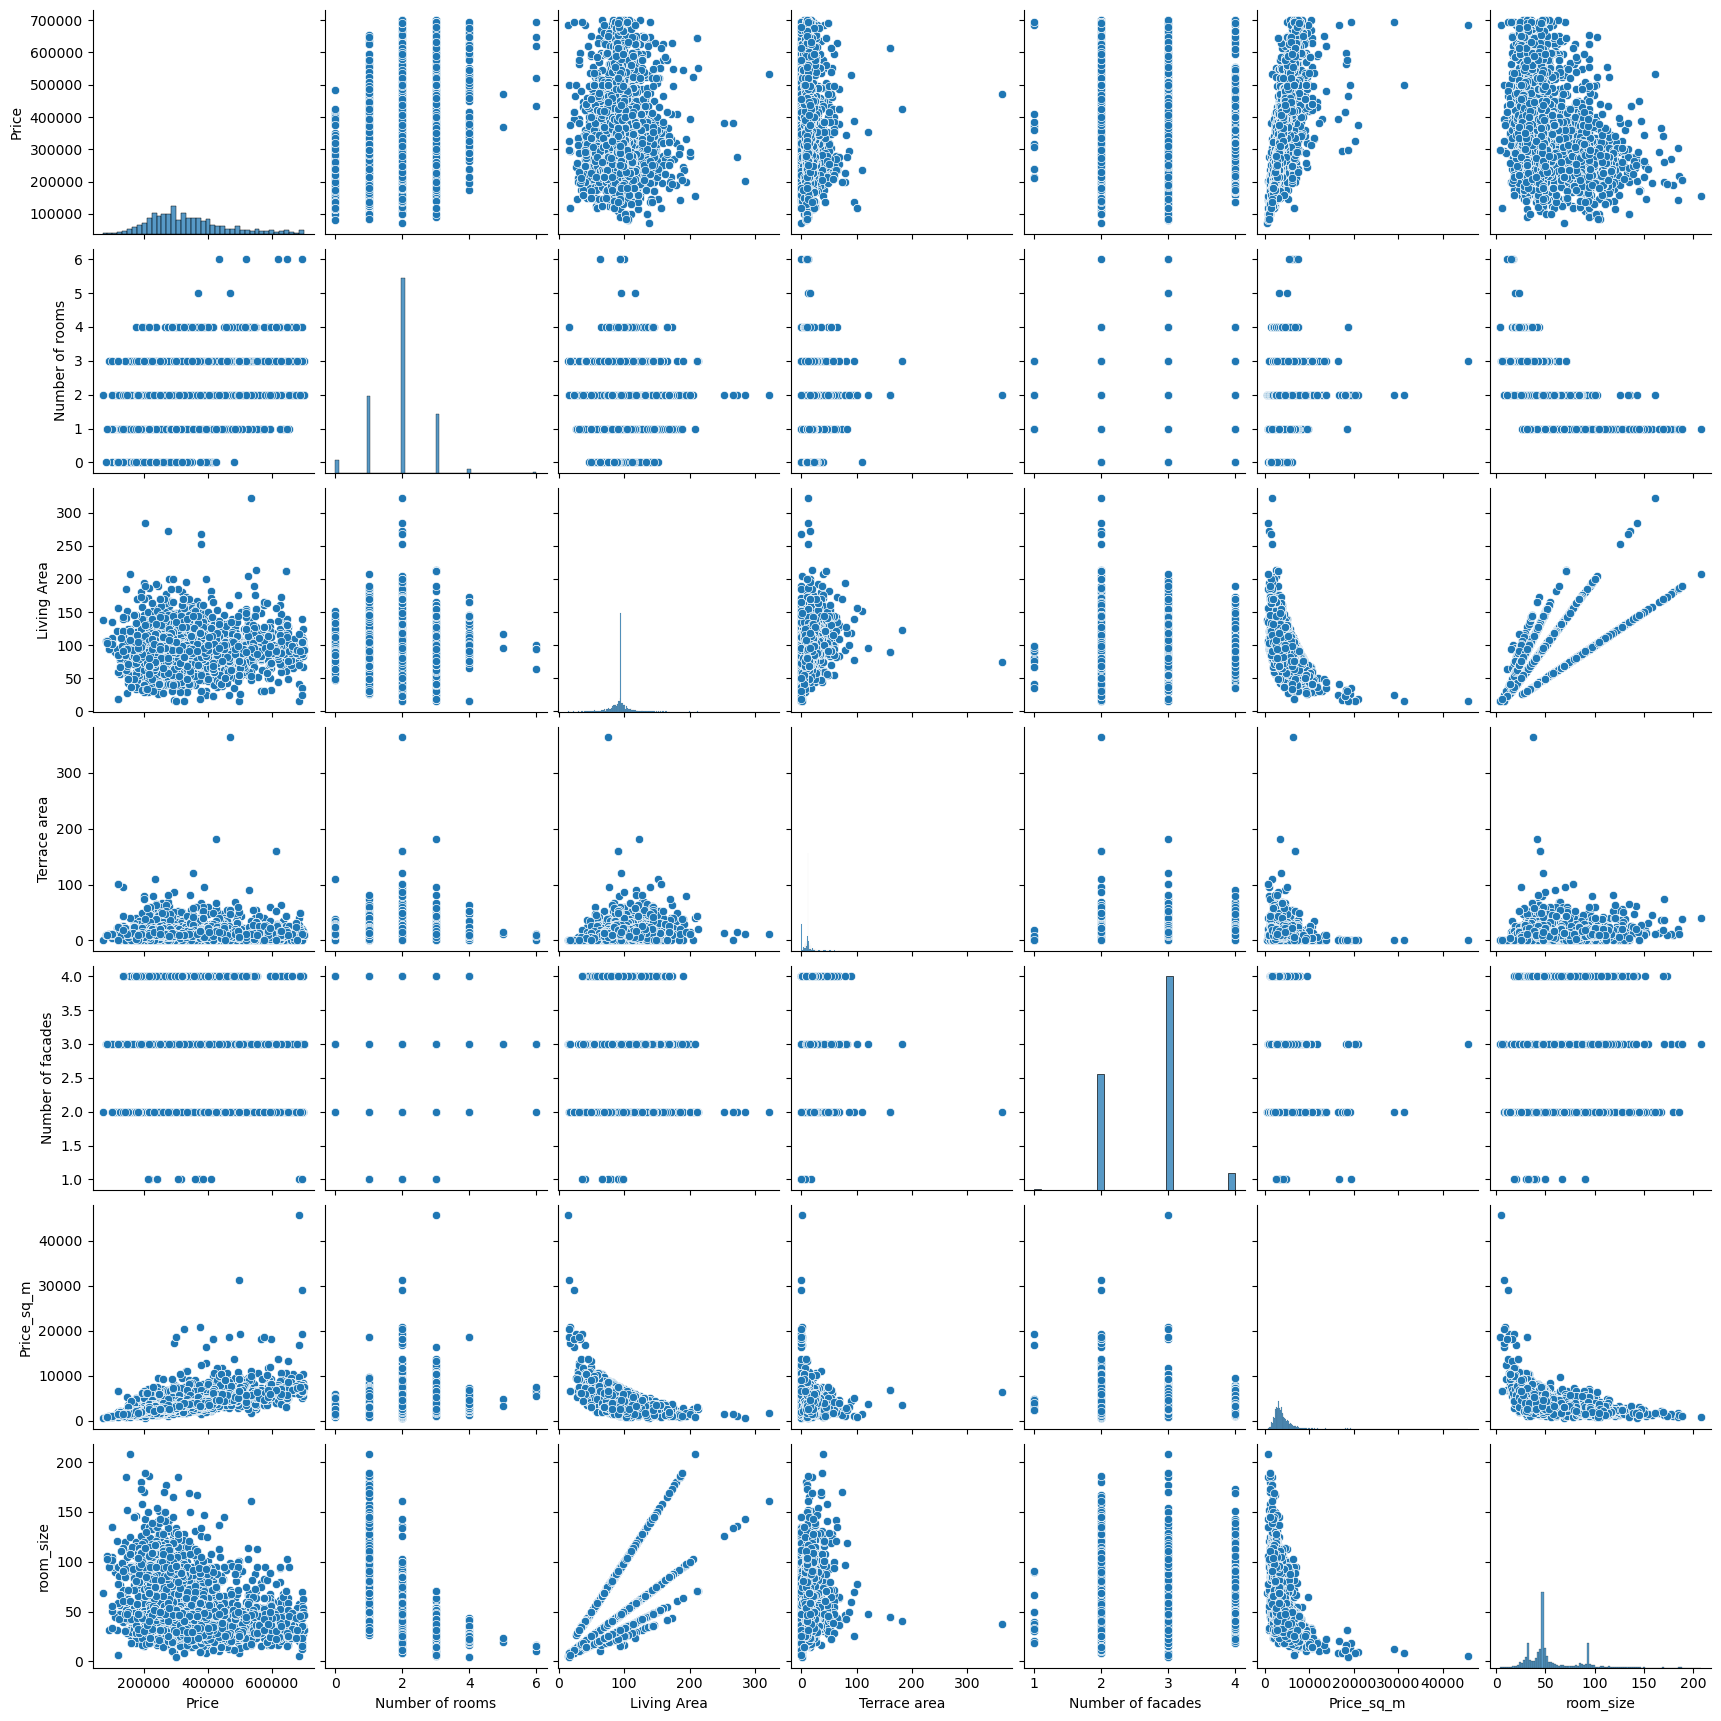

In [14]:
# pairplots

sns.pairplot(data= data, vars= numerical_columns)
plt.show()

Some interactions with price or particular relations between predictors visible

Distributions look skewed and non-normal

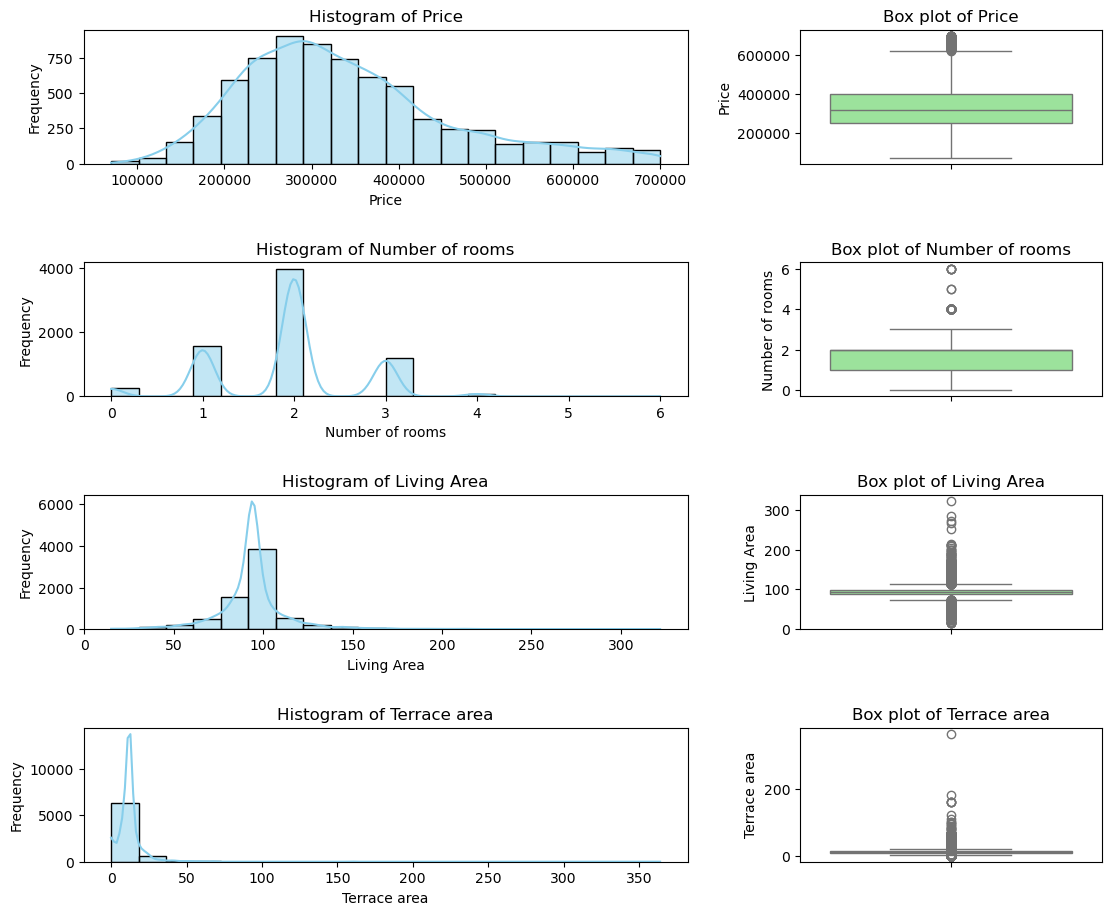

In [15]:
# Create plots with histograms and box plots per variable

# Create a grid for small multiples
fig, axes = plt.subplots(4, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [2, 1]})
fig.tight_layout(pad=5.0)

# Plot histograms and box plots for each variable
for i, col in enumerate(data[numerical_columns[:4]].columns):
    # Histogram
    sns.histplot(data[col], bins=20, kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"Histogram of {col}")
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel("Frequency")
    
    # Box plot
    sns.boxplot(y=data[col], ax=axes[i, 1], color="lightgreen")
    axes[i, 1].set_title(f"Box plot of {col}")
    axes[i, 1].set_xlabel("")
    axes[i, 1].set_ylabel(col)

plt.show()

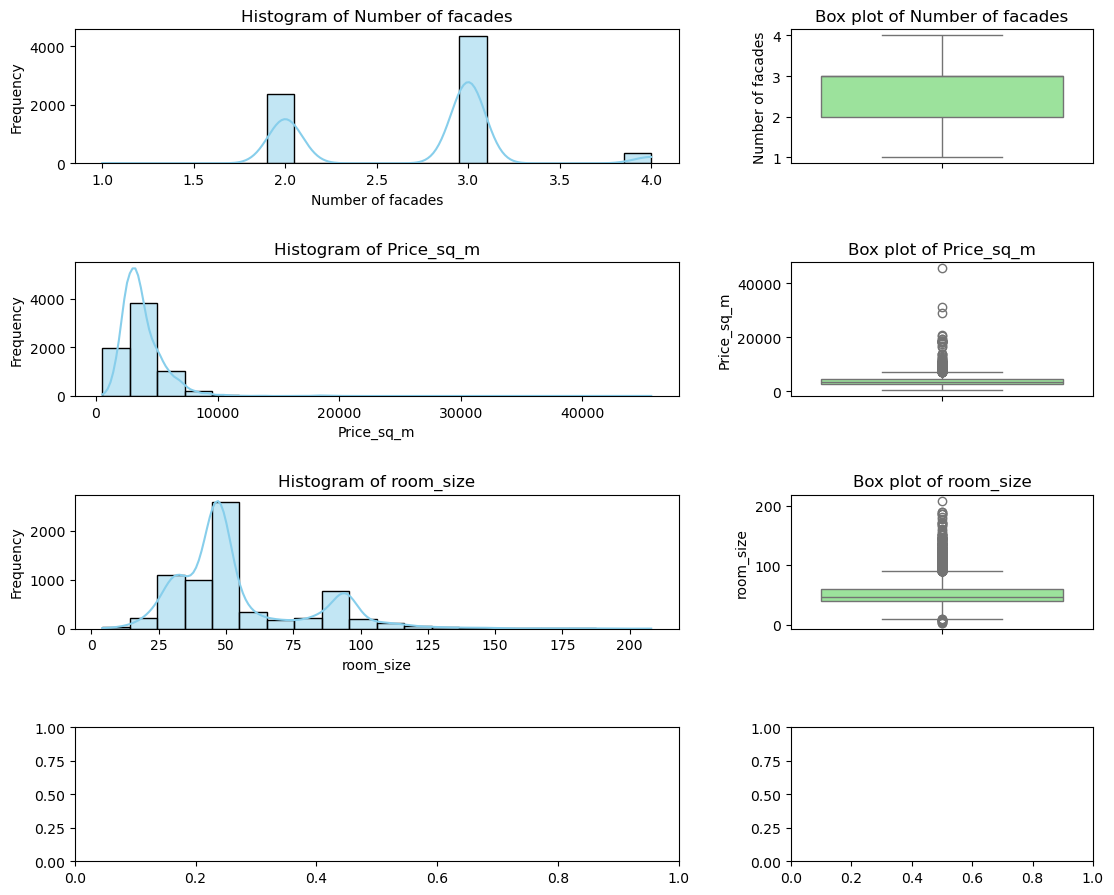

In [16]:
# Create a grid for small multiples
fig, axes = plt.subplots(4, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [2, 1]})
fig.tight_layout(pad=5.0)

# Plot histograms and box plots for each variable
for i, col in enumerate(data[numerical_columns[4:8]].columns):
    # Histogram
    sns.histplot(data[col], bins=20, kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"Histogram of {col}")
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel("Frequency")
    
    # Box plot
    sns.boxplot(y=data[col], ax=axes[i, 1], color="lightgreen")
    axes[i, 1].set_title(f"Box plot of {col}")
    axes[i, 1].set_xlabel("")
    axes[i, 1].set_ylabel(col)

plt.show()

In [18]:
# Check normality

shap = []
KS = []
var = []

for variable in numerical_columns[:6]:
    shap.append(shapiro(data[variable]).pvalue)
    KS.append(kstest(data[variable], 'norm', args=(data[variable].mean(), data[variable].std())).pvalue)
    var.append(variable)

normality = pd.DataFrame({'Variables': var, 'Shapiro-Wilk': shap, 'Kolmogorov-Smirnov': KS})

In [19]:
normality

,Variables,Shapiro-Wilk,Kolmogorov-Smirnov
0,Price,4.744588e-44,9.225168e-42
1,Number of rooms,1.169573e-63,0.000000e+00
2,Living Area,1.119064e-65,8.839327e-185
3,Terrace area,1.990041e-86,0.000000e+00
4,Number of facades,1.357209e-75,0.000000e+00
5,Price_sq_m,1.044973e-71,1.719687e-95


In [179]:
normality.to_excel("./Results-Graphs/normality.xlsx", index= False)

In [178]:
# Perform Kolmogorov-Smirnov test
ks_results = {}
for col in numerical_columns:
    stat, p_value = kstest(data[col].dropna(), 'norm', args=(data[col].mean(), data[col].std()))
    ks_results[col] = (stat, p_value)

# Print results
print("Kolmogorov-Smirnov Test Results:")
for col, (stat, p_value) in ks_results.items():
    print(f"{col}: KS-statistic = {stat:.3f}, p-value = {p_value:.3f}")
    if p_value < 0.05:
        print(f"  -> {col} is not normally distributed (reject H0)")
    else:
        print(f"  -> {col} is normally distributed (fail to reject H0)")


Kolmogorov-Smirnov Test Results:
Garden area: KS-statistic = 0.417, p-value = 0.000
  -> Garden area is not normally distributed (reject H0)
Surface area of the plot of land: KS-statistic = 0.389, p-value = 0.000
  -> Surface area of the plot of land is not normally distributed (reject H0)
Price: KS-statistic = 0.109, p-value = 0.000
  -> Price is not normally distributed (reject H0)
Number of rooms: KS-statistic = 0.230, p-value = 0.000
  -> Number of rooms is not normally distributed (reject H0)
Living Area: KS-statistic = 0.220, p-value = 0.000
  -> Living Area is not normally distributed (reject H0)
Terrace area: KS-statistic = 0.219, p-value = 0.000
  -> Terrace area is not normally distributed (reject H0)
Number of facades: KS-statistic = 0.279, p-value = 0.000
  -> Number of facades is not normally distributed (reject H0)
Price_sq_m: KS-statistic = 0.109, p-value = 0.000
  -> Price_sq_m is not normally distributed (reject H0)
prop_habitable_area: KS-statistic = nan, p-value = na

c:\Users\kvnpo\anaconda3\envs\ImmoEliza\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2110: RuntimeWarning: invalid value encountered in subtract
  x = np.asarray((x - loc)/scale, dtype=dtyp)


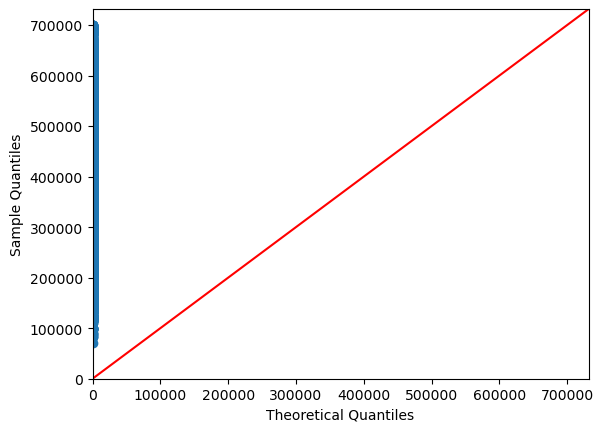

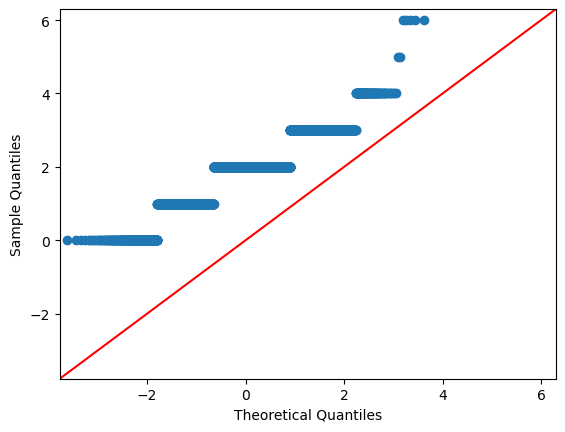

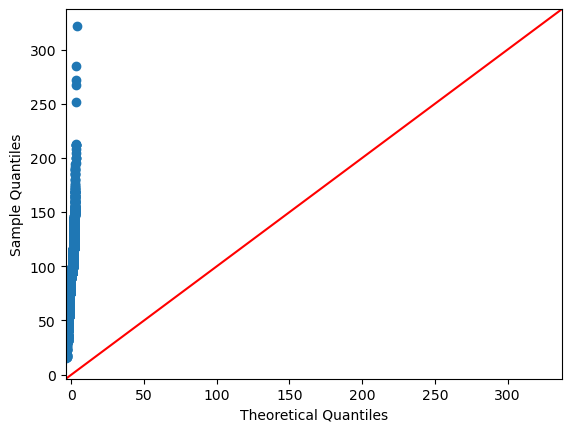

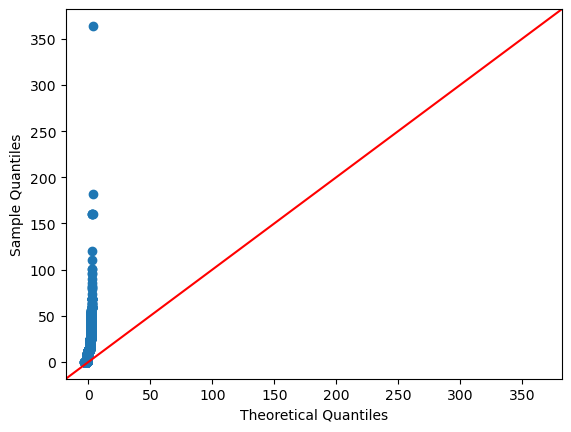

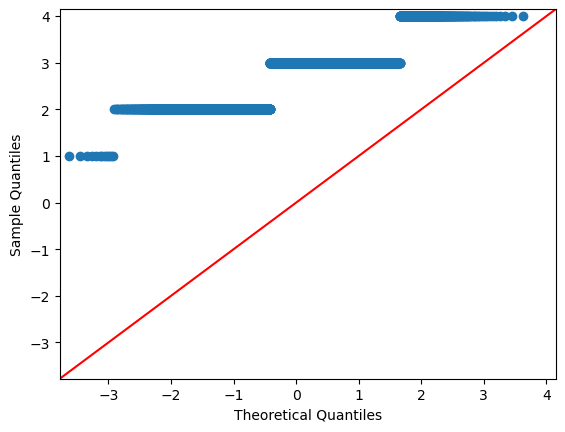

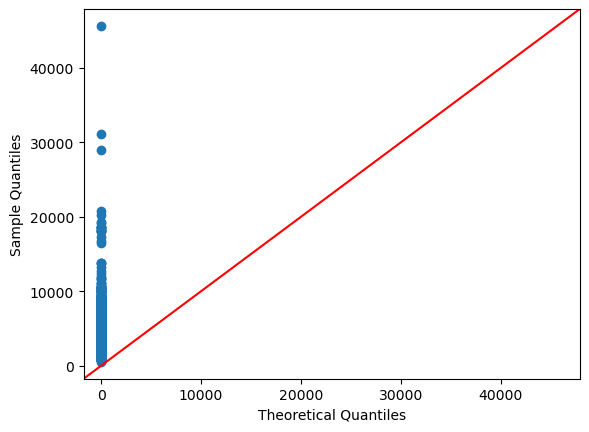

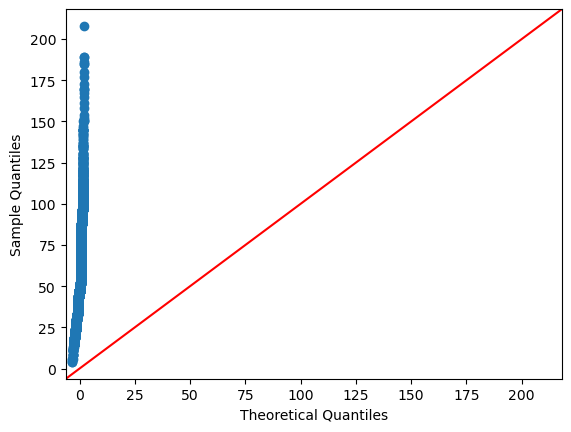

In [20]:
# create Q-Q plot with 45-degree line (reference line)

for i, col in enumerate(data[numerical_columns].columns):
    sm.qqplot(data[col], line='45')
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()



None of the numerical data have normal distibution

## Relationships - correlations numerical variables

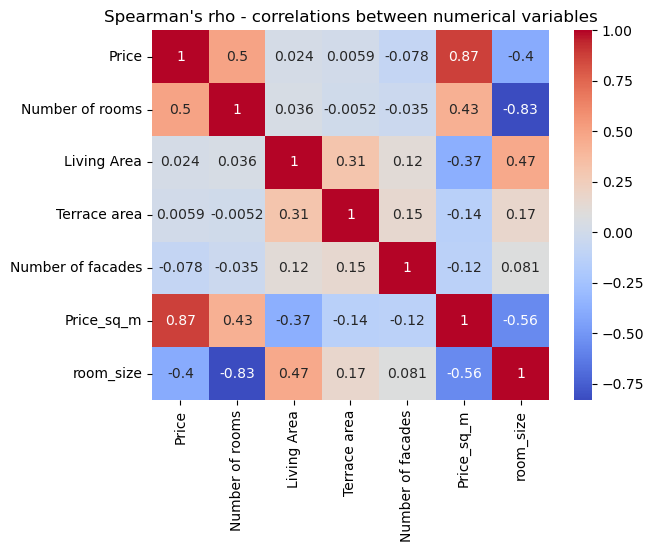

In [21]:
# None of data are normally distributed, use non-param alternative to calculate correlations
# Spearman's rho and heatmap

correlations = data[numerical_columns].corr(method= 'spearman')
sns.heatmap(correlations, annot= True, cmap= 'coolwarm')

plt.title("Spearman's rho - correlations between numerical variables")

plt.show()

1. None of the variables are normally distributed, many show high skewness
2. Surface of the land has to be excluded (same as Garden area)
3. Correlations between predictors, check VIF - multicollinearity
4. Price most affected by Number of rooms, living area and Surface of the plot
5. Subdividing houses and apartments returns similar results (order importance slightly different), still no normal data

In [24]:
# Check VIF 

numerical_predictors = ['Number of rooms',
 'Living Area',
 'Terrace area',
 'Number of facades']
X = data[numerical_predictors]
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

#vif.to_excel('./Results-Graphs/VIF.xlsx', index= False)

             Feature        VIF
0    Number of rooms   6.351637
1        Living Area  17.239232
2       Terrace area   2.616685
3  Number of facades  14.987504


1. Relatively high VIF for two variables strongly associated to the response, need to be dealt with
2. Quite low for others

## Dimension reduction of numerical data

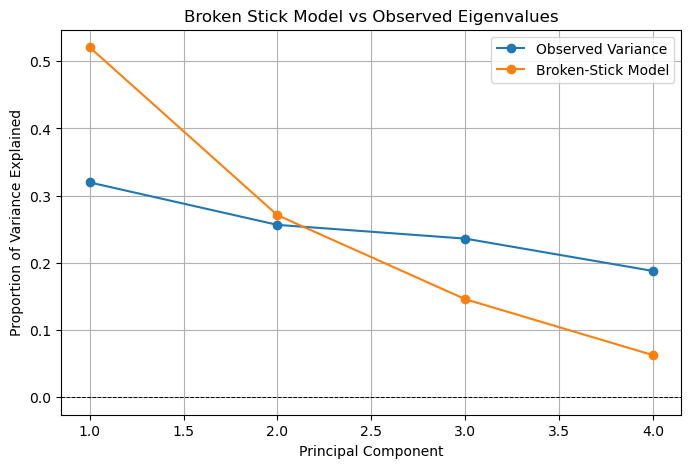

Components exceeding broken stick model:
PC3: Observed = 0.236, Broken Stick = 0.146
PC4: Observed = 0.188, Broken Stick = 0.062


In [25]:
# Standardize data - PCA operates on covariance matrix default, so need to scale

numerical_data = data[numerical_predictors]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Perform PCA

pca = PCA()
pca.fit(scaled_data)

# Broken stick

def broken_stick(n_components, total_components):
    """Calculate broken-stick model values for n_components."""
    return [np.sum([1 / k for k in range(i, total_components + 1)]) / total_components for i in range(1, n_components + 1)]

n_components = len(pca.explained_variance_ratio_)
broken_stick_values = broken_stick(n_components, n_components)

# Step 5: Create a DataFrame for Comparison
explained_variance = pca.explained_variance_ratio_
comparison_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(n_components)],
    'Explained Variance': explained_variance,
    'Broken-Stick Value': broken_stick_values
})

# Step 6: Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), explained_variance, 'o-', label='Observed Variance')
plt.plot(range(1, n_components + 1), broken_stick_values, 'o-', label='Broken-Stick Model')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Broken Stick Model vs Observed Eigenvalues')
plt.legend()
plt.grid()
plt.show()

# Print components that exceed broken stick model
print("\
Components exceeding broken stick model:")
for i in range(n_components):
    if pca.explained_variance_ratio_[i] > broken_stick_values[i]:
        print(f"PC{i+1}: Observed = {pca.explained_variance_ratio_[i]:.3f}, Broken Stick = {broken_stick_values[i]:.3f}")



The broken stick model suggests that we should retain components whose observed eigenvalues exceed the broken stick values. In this case, PC1, PC4, PC5, and PC6 exceed their corresponding broken stick values. However, since we typically want consecutive components and PC2 and PC3 explain substantial variance (even though they don't exceed the broken stick threshold), a reasonable choice would be to retain the first 4 components, which together explain about 87% of the total variance.

This analysis provides additional support for using 4 principal components in your analysis.

In [26]:
explained_variance_ratio = pca.explained_variance_ratio_

explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Explained Variance': np.cumsum(explained_variance_ratio)
})

explained_variance_df.to_excel('./Results-Graphs/PCA_totalData_AllPred_ExplainedVariance.xlsx', index= False)
explained_variance_df

,Principal Component,Explained Variance Ratio,Cumulative Explained Variance
0,PC1,0.319699,0.319699
1,PC2,0.256469,0.576168
2,PC3,0.236008,0.812176
3,PC4,0.187824,1.000000


In [27]:
correlations = pd.DataFrame(
    {f'PC{i+1}': [np.corrcoef(scaled_data[:, j], pca_scores[f'PC{i+1}'])[0, 1] 
                  for j in range(scaled_data.shape[1])] 
     for i in range(principal_components.shape[1])},
    index=data[numerical_predictors].columns
)

NameError: name 'principal_components' is not defined

In [105]:
correlations

,PC1,PC2,PC3,PC4,PC5,PC6
Garden area,0.621815,-0.384681,-0.041343,-0.545399,-0.403805,0.056016
Surface area of the plot of land,0.728107,-0.212551,-0.270264,-0.230067,0.535922,-0.107219
Number of rooms,0.710375,0.560111,-0.000514,0.091000,-0.187920,-0.371548
Living Area,0.779421,0.437222,-0.026742,0.141652,0.021133,0.424396
Terrace area,0.419799,-0.236579,0.863672,0.101321,0.104439,-0.026401
Number of facades,0.451716,-0.543246,-0.263155,0.639929,-0.145972,-0.027733


In [28]:
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_),
                        columns=[f'PC{i+1}' for i in range(len(numerical_predictors))],
                         index = numerical_predictors )

loadings.to_excel('./Results-Graphs/PCA_totalData_AllPred_Loadings.xlsx', index= True)
loadings

,PC1,PC2,PC3,PC4
Number of rooms,0.077163,0.834951,0.540708,-0.068401
Living Area,0.768611,0.093626,-0.115082,0.622389
Terrace area,0.746083,0.083057,-0.290925,-0.593267
Number of facades,0.354427,-0.559655,0.744257,-0.085972


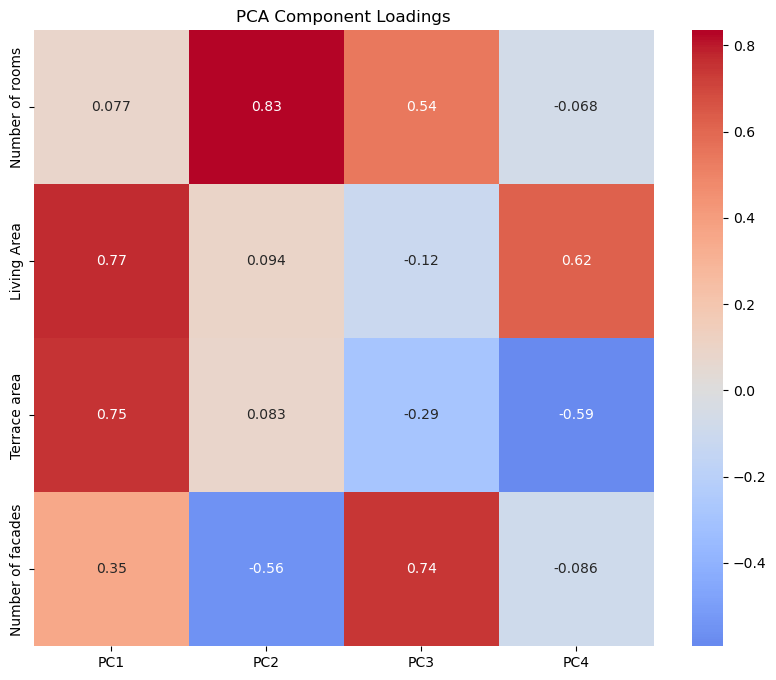

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Component Loadings')
plt.show()

In [30]:
loadings

,PC1,PC2,PC3,PC4
Number of rooms,0.077163,0.834951,0.540708,-0.068401
Living Area,0.768611,0.093626,-0.115082,0.622389
Terrace area,0.746083,0.083057,-0.290925,-0.593267
Number of facades,0.354427,-0.559655,0.744257,-0.085972


In [32]:
principal_components = PCA()
principal_components = principal_components.fit_transform(scaled_data)

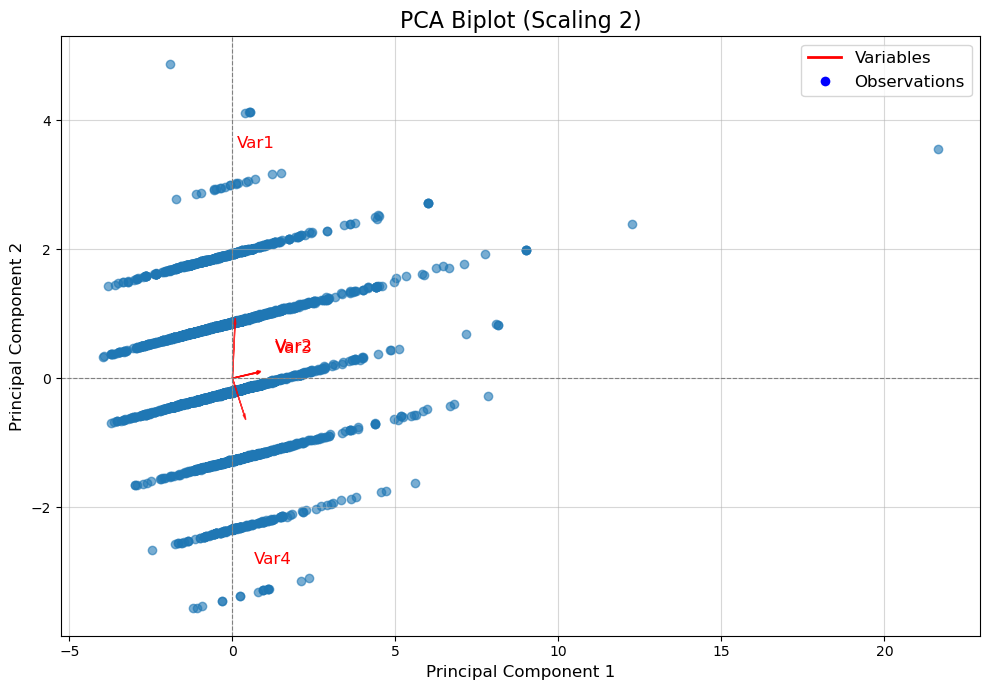

In [33]:
# Get PCA loadings (arrows)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Biplot
plt.figure(figsize=(10, 7))

# Scatter plot of the first two principal components (observations)
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.6, label='Observations')

# Add arrows for variable projections (loadings)
for i, (x, y) in enumerate(zip(loadings[:, 0], loadings[:, 1])):

    plt.arrow(0, 0, x, y, color='r', alpha=0.8, head_width=0.05, head_length=0.1)
    offset_factor = 1.1  # Space factor for the labels
    offset_angle = np.arctan2(y, x)  # Angle of the arrow
    x_offset = offset_factor * np.cos(offset_angle)
    y_offset = offset_factor * np.sin(offset_angle)
    
    # Place the label further away from the arrow
    plt.text(x + 0.5 *x_offset, y + 2.5* y_offset, f"Var{i+1}", color='red', fontsize=12)

# Add labels and grid
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("PCA Biplot (Scaling 2)", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

# Create custom legend entries
custom_line = Line2D([0], [0], color='red', lw=2, label='Variables')  # Red line for variables
custom_scatter = Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Observations')  # Blue dots for observations

# Add the custom legend entries
plt.legend(handles=[custom_line, custom_scatter], fontsize=12)

# Show plot
plt.tight_layout()

# Show plot
plt.show()

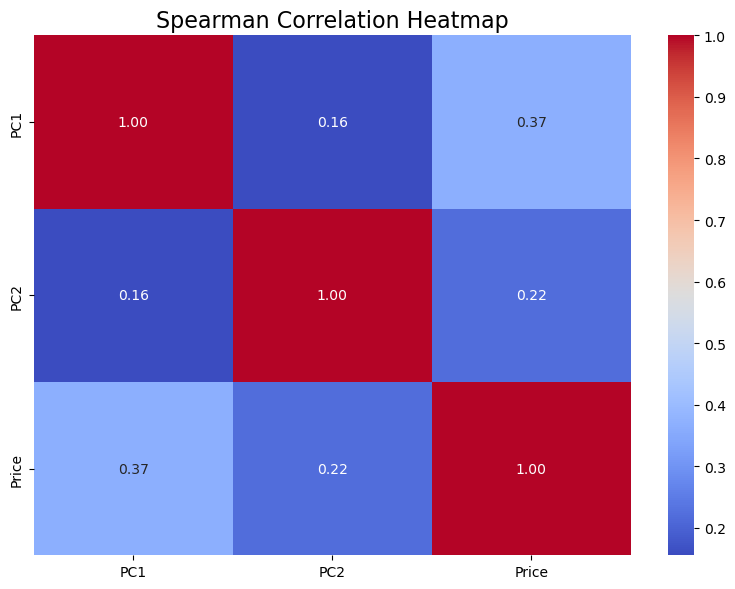

In [147]:
pca = PCA(n_components=2)
scores = pca.fit_transform(scaled_data)

# Create a DataFrame for the first two principal components
scores_df = pd.DataFrame(scores, columns=["PC1", "PC2"])

# Add the response variable to the DataFrame
scores_df["Price"] = data['Price']

# Calculate Spearman correlation
correlation_matrix = scores_df.corr(method="spearman")

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Spearman Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

The PCA results actually show a fairly clear structure:

    The first component (PC1) explains 42.1% of the variance and is strongly related to land measurements (Surface area, Garden area)
    PC2 explains 18.8% and is more related to the living space features
    The first 4 components together explain 87% of the variance, suggesting we could reduce dimensionality while retaining most of the information


## Check for associations of categorical variables with price

In [37]:
# Separate categorical columns

categorical_columns = ['Locality',
 'Subtype of property',
 'State of the building']

binary_columns =  ['Fully equipped kitchen',
 'Fireplace',
 'Terrace',
 'Garden',
 'Swimming pool',
 'Compound Listing',
 'Furnished']

In [38]:
# Kruskal-Wallis test for categoricals

results = []

predictor_data = data[categorical_columns]
response_data = data[['Price']]

for cat_col in predictor_data.columns:
    # Get unique categories for this categorical variable
    categories = data[cat_col].unique()

    # Group the 'Price' data by the categorical variable
    groups = [data[data[cat_col] == category]['Price'] for category in categories]
    stat, p_value = kruskal(*groups)
    
    if p_value < 0.05:
        Difference = "Significant"
    else:
        Difference = "Not Significant"
    results.append({
        "Categorical Variable": cat_col,
        "H-statistic": stat,
        "P-value": p_value,
        "Difference": Difference
    })

results_df = pd.DataFrame(results)
results_df.to_excel('./Results-Graphs/Kruskal_AllData.xlsx', index= False)
print(results_df)
    


    Categorical Variable  H-statistic        P-value   Difference
0               Locality  2311.406669  2.464937e-268  Significant
1    Subtype of property   562.472997  2.717974e-116  Significant
2  State of the building   527.114406  1.209418e-110  Significant


             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
   group1       group2      meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------------------
   APARTMENT       DUPLEX    70376.381    0.0   44370.6201   96382.1419   True
   APARTMENT  FLAT_STUDIO -100766.0623    0.0 -123330.0727  -78202.0518   True
   APARTMENT GROUND_FLOOR     965.3654    1.0  -18820.9532   20751.6841  False
   APARTMENT          KOT -130182.7401    0.0 -184440.7309  -75924.7492   True
   APARTMENT         LOFT  109748.1859    0.0   39807.0279  179689.3439   True
   APARTMENT    PENTHOUSE  126127.7814    0.0  100782.9753  151472.5876   True
   APARTMENT SERVICE_FLAT  -48552.4471 0.1323 -103418.9494    6314.0552  False
   APARTMENT      TRIPLEX  -11158.1289    1.0 -101930.4194   79614.1615  False
      DUPLEX  FLAT_STUDIO -171142.4433    0.0 -204922.3639 -137362.5227   True
      DUPLEX GROUND_FLOOR  -69411.0156    0.0 -10140

C:\Users\kvnpo\AppData\Local\Temp\ipykernel_15344\2884786979.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Subtype of property', y='Price', data=data, palette='Set2')


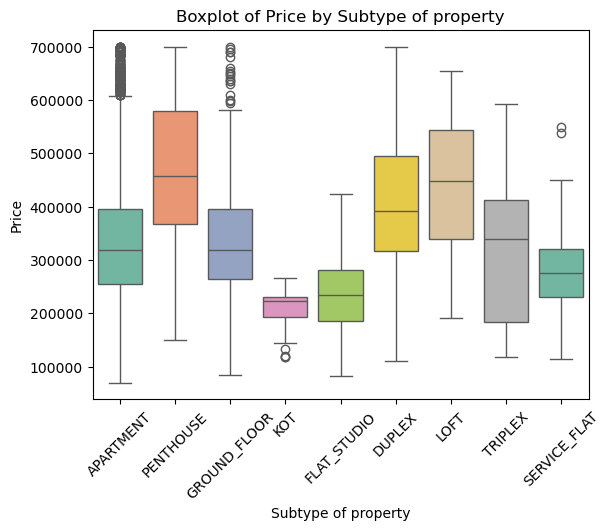

In [41]:
# All variables significant - perform post-hoc tests

tukey_results = pairwise_tukeyhsd(data['Price'], data['Subtype of property'], alpha= 0.05)
print(tukey_results)
sns.boxplot(x='Subtype of property', y='Price', data=data, palette='Set2')
plt.xticks(rotation=45)

# Add labels and title
#plt.xlabel('Category')
#plt.ylabel('Value')
plt.title('Boxplot of Price by Subtype of property')

# Show the plot
plt.show()

# No clear visible difference in price between houses and apartments
# Houses have greater variance in price
# Both groups have outliers

In [42]:
# Mann-Whitney-U test for categoricals

results = []

predictor_data = data[binary_columns]
response_data = data[['Price']]

for cat_col in predictor_data.columns:
    # Get unique categories for this categorical variable
    categories = data[cat_col].unique()

    # Group the 'Price' data by the categorical variable
    groups = [data[data[cat_col] == category]['Price'] for category in categories]
    result = kruskal(*groups)

    results.append({
        "Categorical Variable": cat_col,
        "U-statistic": result.statistic,
        "P-value": result.pvalue,
    })

results_df = pd.DataFrame(results)
results_df.to_excel('./Results-Graphs/MWU_AllData.xlsx', index= False)
print(results_df)

     Categorical Variable  U-statistic       P-value
0  Fully equipped kitchen     0.862545  3.530274e-01
1               Fireplace    25.612512  4.173245e-07
2                 Terrace   283.047685  1.627292e-63
3                  Garden     2.153866  1.422114e-01
4           Swimming pool    22.970815  1.644796e-06
5        Compound Listing   303.463395  5.797336e-68
6               Furnished     1.399840  2.367504e-01


## Associations between categorical variables

In [43]:
# Create combinations of categorical feature names

categoricals = categorical_columns + binary_columns

two_column_combinations = list(itertools.combinations(categoricals, 2))

In [44]:
contingency_tables = [
    pd.crosstab(data[comb[0]], data[comb[1]])
    for comb in two_column_combinations
]


In [45]:
for table, name in zip(contingency_tables, two_column_combinations):
    print(f"Chi square p-value: {chi2_contingency(table).pvalue} for {name}")

Chi square p-value: 0.0 for ('Locality', 'Subtype of property')
Chi square p-value: 0.0 for ('Locality', 'State of the building')
Chi square p-value: 0.0 for ('Locality', 'Fully equipped kitchen')
Chi square p-value: 2.311876418230175e-05 for ('Locality', 'Fireplace')
Chi square p-value: 5.712081164409604e-170 for ('Locality', 'Terrace')
Chi square p-value: 4.8656541828136654e-51 for ('Locality', 'Garden')
Chi square p-value: 0.0 for ('Locality', 'Swimming pool')
Chi square p-value: 0.0 for ('Locality', 'Compound Listing')
Chi square p-value: 0.01188799479430683 for ('Locality', 'Furnished')
Chi square p-value: 1.3279734228031947e-39 for ('Subtype of property', 'State of the building')
Chi square p-value: 1.1588933345154746e-12 for ('Subtype of property', 'Fully equipped kitchen')
Chi square p-value: 0.00013112690159582902 for ('Subtype of property', 'Fireplace')
Chi square p-value: 9.474755328131693e-49 for ('Subtype of property', 'Terrace')
Chi square p-value: 1.9868498119243862e-169